# Preprocessing

First, we need to load the dataset and perform some pre-processing tasks. The dataset can be found via https://drive.google.com/drive/folders/1Qng_4-EaS_G1V00QC_2lCbtq7XaczbPa?usp=sharing. Further, an R script will be included to build your own dataset.

In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import time
import sys
import sklearn
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
plt.style.use("seaborn")

In [2]:
# Connect with Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import the data and drop the index column
PATH = "/content/drive/MyDrive/Master Thesis/final_dataset.csv" # insert path to the file here
data = pd.read_csv(PATH)
data = data.drop(data.columns[[0]], axis = 1)
data.head(5)

,date,site,NOx,lag,spring,summer,autumn,urban,traffic,n_agri,area_agri,n_indus,area_indus,FH,FF,FX,T,SQ,Q,DR,RH,P,U,M,R,S,O,Y,DD_E,DD_NE,DD_NW,DD_S,DD_SE,DD_SW,DD_W
0,2012-01-01 01:00:00,NL10131,8.30,8.54,0,0,0,0,0,76,62367,10,4008,60,60,80,108,0,0,9,2,10095,97,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0
1,2012-01-01 02:00:00,NL10131,6.38,8.30,0,0,0,0,0,76,62367,10,4008,60,60,80,111,0,0,0,-1,10092,95,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0
2,2012-01-01 03:00:00,NL10131,4.90,6.38,0,0,0,0,0,76,62367,10,4008,70,80,110,110,0,0,5,4,10091,95,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0
3,2012-01-01 04:00:00,NL10131,4.32,4.90,0,0,0,0,0,76,62367,10,4008,70,70,110,111,0,0,3,1,10088,97,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0
4,2012-01-01 05:00:00,NL10131,4.48,4.32,0,0,0,0,0,76,62367,10,4008,70,70,100,111,0,0,9,3,10090,98,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0


In [4]:
# Convert all features to the correct type
data['M'] = data['M'].fillna(0)
data['R'] = data['R'].fillna(0)
data['S'] = data['S'].fillna(0)
data['O'] = data['O'].fillna(0)
data['Y'] = data['Y'].fillna(0)
dtypes = {'M': 'int64', 'R': 'int64', 'S': 'int64', 'O': 'int64', 'Y': 'int64'}
data = data.astype(dtypes)
print(data.dtypes)

date           object
site           object
NOx           float64
lag           float64
spring          int64
summer          int64
autumn          int64
urban           int64
traffic         int64
n_agri          int64
area_agri       int64
n_indus         int64
area_indus      int64
FH              int64
FF              int64
FX              int64
T               int64
SQ              int64
Q               int64
DR              int64
RH              int64
P               int64
U               int64
M               int64
R               int64
S               int64
O               int64
Y               int64
DD_E            int64
DD_NE           int64
DD_NW           int64
DD_S            int64
DD_SE           int64
DD_SW           int64
DD_W            int64
dtype: object


In [5]:
# Create subsets of dummy and continuous columns
dummies = ["spring", "summer", "autumn", "urban", "traffic", "M", "R", "S", "O", "Y", "DD_E", "DD_NE", "DD_NW", "DD_S", "DD_SE", "DD_SW", "DD_W"]
continuous = ["n_agri", "area_agri", "n_indus", "area_indus", "FH", "FF", "FX", "T", "SQ", "Q", "DR", "RH", "P", "U"]

# Exploratory Data Analysis

Next, we create some exploratory plots using the seaborn package. These plots are featured in section 4.3 of the Master Thesis, but feel free to create your own plots!

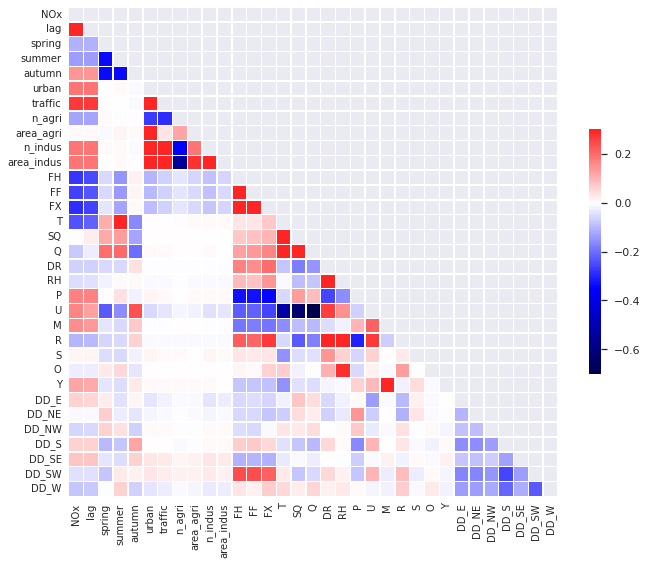

In [6]:
# Correlation plot between variables
corr = data[data.columns[2:]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.set_theme(style="white")
sns.heatmap(corr, mask=mask, cmap="seismic", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

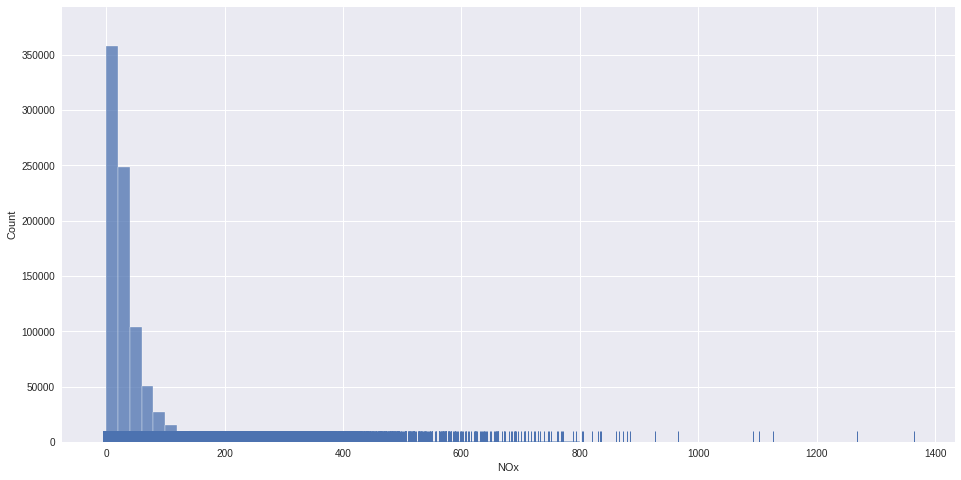

In [ ]:
# Histogram and rug plot to check the distribution of NOx
plt.figure(figsize=(16,8))
ax = sns.histplot(x = data["NOx"], bins = [0,20,40,60,80,100,120,140,160,200,400,800])
ax = sns.rugplot(x = data["NOx"])

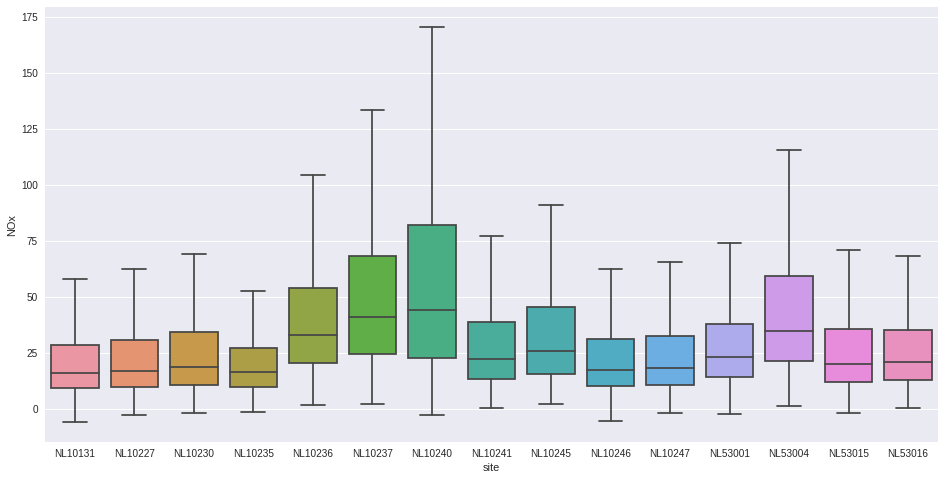

In [ ]:
# Boxplot to visualise differences in NOx between locations
plt.figure(figsize = (16,8))
ax = sns.boxplot(y = "NOx", x = "site", data = data, showfliers = False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58c6f5d650>,
      dtype=object)

<Figure size 1152x576 with 0 Axes>

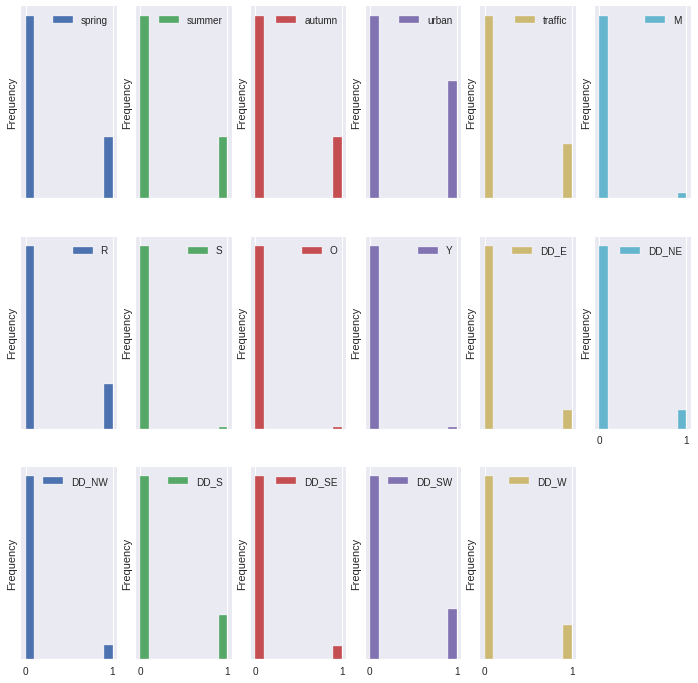

In [ ]:
# Histograms to check the distribution of the dummy variables
plt.figure(figsize = (16,8))
ax = data[dummies].plot.hist(subplots = True, legend = True, layout = (3,6), figsize = (12,12), xticks = [0,1], yticks = [])

n_agri           AxesSubplot(0.125,0.657941;0.133621x0.222059)
area_agri     AxesSubplot(0.285345,0.657941;0.133621x0.222059)
n_indus        AxesSubplot(0.44569,0.657941;0.133621x0.222059)
area_indus    AxesSubplot(0.606034,0.657941;0.133621x0.222059)
FH            AxesSubplot(0.766379,0.657941;0.133621x0.222059)
FF               AxesSubplot(0.125,0.391471;0.133621x0.222059)
FX            AxesSubplot(0.285345,0.391471;0.133621x0.222059)
T              AxesSubplot(0.44569,0.391471;0.133621x0.222059)
SQ            AxesSubplot(0.606034,0.391471;0.133621x0.222059)
Q             AxesSubplot(0.766379,0.391471;0.133621x0.222059)
DR                  AxesSubplot(0.125,0.125;0.133621x0.222059)
RH               AxesSubplot(0.285345,0.125;0.133621x0.222059)
P                 AxesSubplot(0.44569,0.125;0.133621x0.222059)
U                AxesSubplot(0.606034,0.125;0.133621x0.222059)
dtype: object

<Figure size 1152x576 with 0 Axes>

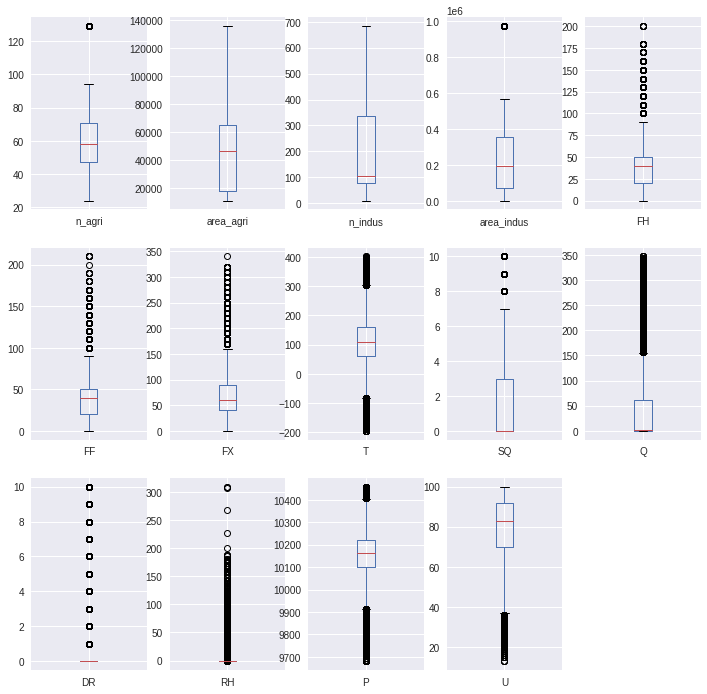

In [ ]:
# Box plots for the distribution of the continuous variables
plt.figure(figsize = (16,8))
ax = data[continuous].plot.box(subplots = True, legend = True, layout = (3,5), figsize = (12,12))

# Analysis

The analysis is divided into three parts. But first, we need to split the data into training, test, and validation sets.

In [7]:
X = data[data.columns[3:]]
y = data["NOx"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
lag_train = X_train[:,0].reshape(-1,1)
X_val = scaler.transform(X_val)
lag_val = X_val[:,0].reshape(-1,1)
X_test = scaler.transform(X_test)
lag_test = X_test[:,0].reshape(-1,1)
seed = 42

## Model selection

In the first stage, five machine learning models are compared against each other.

In [ ]:
# Compare models using cross validation on the training set
# Code adapted from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
t1 = time.time()
models = []
models.append(('LR', LinearRegression()))
models.append(('EN', ElasticNet()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))

results = []
names = []
scoring = 'neg_root_mean_squared_error'
for name, model in models:
	kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, verbose = 3, n_jobs = -1)
	results.append(cv_results)
	names.append(name)
	print("%s: %f" % (name, cv_results.mean()))
t2 = time.time()
runtime = t2 - t1
print('runtime: %s seconds' % runtime)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LR: -15.097903


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


EN: -36.791660


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


DT: -19.985842
RFR: -14.038730


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 33.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KNN: -23.418643
4999.1781125068665


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 49.6min finished


In [ ]:
# Calculate RMSE for the baseline model
model = LinearRegression()
results_b = []
scoring = 'neg_root_mean_squared_error'

kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
cv_results_b = cross_val_score(model, lag_train, y_train, cv=kfold, scoring=scoring, n_jobs = -1)
results_b.append(cv_results_b)
print(cv_results_b.mean())

-15.437779673909608


In [8]:
# retrain ElasticNet with different hyperparameters to see if its performance can be improved
results_c = []
for alpha in [.001, .01, 0.1, 1.0]:
  for l1 in [0.0, 0.5, 1.0]:
    model = ElasticNet(alpha = alpha, l1_ratio = l1)
    scoring = 'neg_root_mean_squared_error'
    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    cv_results_c = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs = -1)
    results_c.append(cv_results_c)
    print('Alpha: %s' % alpha)
    print('L1 ratio: %s' % l1)
    print('RMSE: %s' % cv_results_c.mean())
    print('')

Alpha: 0.001
L1 ratio: 0.0
RMSE: -21.72448105903987

Alpha: 0.001
L1 ratio: 0.5
RMSE: -18.51714595134721

Alpha: 0.001
L1 ratio: 1.0
RMSE: -15.098194465000699

Alpha: 0.01
L1 ratio: 0.0
RMSE: -30.83755487963893

Alpha: 0.01
L1 ratio: 0.5
RMSE: -29.038011192540893

Alpha: 0.01
L1 ratio: 1.0
RMSE: -15.103661093999875

Alpha: 0.1
L1 ratio: 0.0
RMSE: -34.357393268435125

Alpha: 0.1
L1 ratio: 0.5
RMSE: -33.54765004365303

Alpha: 0.1
L1 ratio: 1.0
RMSE: -15.450057752031205

Alpha: 1.0
L1 ratio: 0.0
RMSE: -36.973593678973145

Alpha: 1.0
L1 ratio: 0.5
RMSE: -36.79165990716642

Alpha: 1.0
L1 ratio: 1.0
RMSE: -33.965710063435836



### Hyperparameter tuning

For the best performing model, which in our case is the Random Forest Regression model, the optimal hyperparameters should be selected. In this section, we will tune the hyperparameters on the validation set. 

In [ ]:
# Tune the hyperparameters of the best model
# (code adapted from https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)
t1 = time.time()
# define parameter grid (feel free to choose different/more parameters if you have enough computational power)
model = RandomForestRegressor()
space = {'max_depth': [5, None], 'n_estimators': [50, 100, 250]}
# define evaluation
cv = KFold(n_splits=3, random_state=seed, shuffle = True)

# tune parameters using grid search
# define search
search = GridSearchCV(model, space, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv, verbose = 3)
# execute search
result = search.fit(X_val, y_val)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
t2 = time.time()
runtime = t2 - t1
print('runtime: %s seconds' % runtime)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Score: -14.338853718957031
Best Hyperparameters: {'max_depth': None, 'n_estimators': 250}
1935.2983136177063


In [9]:
# Tune hyperparameters for the baseline
# define parameter grid
model = LinearRegression()
space = {'fit_intercept': [True, False], 'positive': [True, False]}
# define evaluation
cv = KFold(n_splits=3, random_state=seed, shuffle = True)

# tune parameters using grid search
# define search
search = GridSearchCV(model, space, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv, verbose = 3)
# execute search
result = search.fit(lag_val, y_val)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Score: -15.303594580900858
Best Hyperparameters: {'fit_intercept': True, 'positive': True}
runtime: 0.40703868865966797 seconds


## Comparison with the baseline

Next, we compare the best model with the optimal parameters to the baseline model on the test set.

In [ ]:
t1 = time.time()
# Train RFR and baseline on validation set (due to memory constraints)
model = RandomForestRegressor(max_depth = None, n_estimators = 250)
model.fit(X_val, y_val)
baseline = LinearRegression(fit_intercept = True, positive = True)
baseline.fit(lag_val, y_val)

# Make predictions
yhat = model.predict(X_test)
yhat_baseline = baseline.predict(lag_test)

# Evaluate predictions
rmse = mean_squared_error(y_test, yhat, squared = False)
r2 = r2_score(y_test, yhat)
print("Random Forest Model")
print('RMSE: %.3f' % rmse)
print('R2: %.3f' % r2)
rmse_baseline = mean_squared_error(y_test, yhat_baseline, squared = False)
r2_baseline = r2_score(y_test, yhat_baseline)
print('')
print('Baseline Model')
print('RMSE: %.3f' % rmse_baseline)
print('R2: %.3f' % r2_baseline)
t2 = time.time()
runtime = t2 - t1
print('runtime: %s seconds' % runtime)

Random Forest Model
RMSE: 14.316
R2: 0.861

Baseline Model
RMSE: 15.537
R2: 0.837
583.0851557254791


## Feature importance

Finally, we establish feature importance for the best performing model.

In [ ]:
# Extract feature importance from the trained model
importance = model.feature_importances_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text major ticklabel objects>)

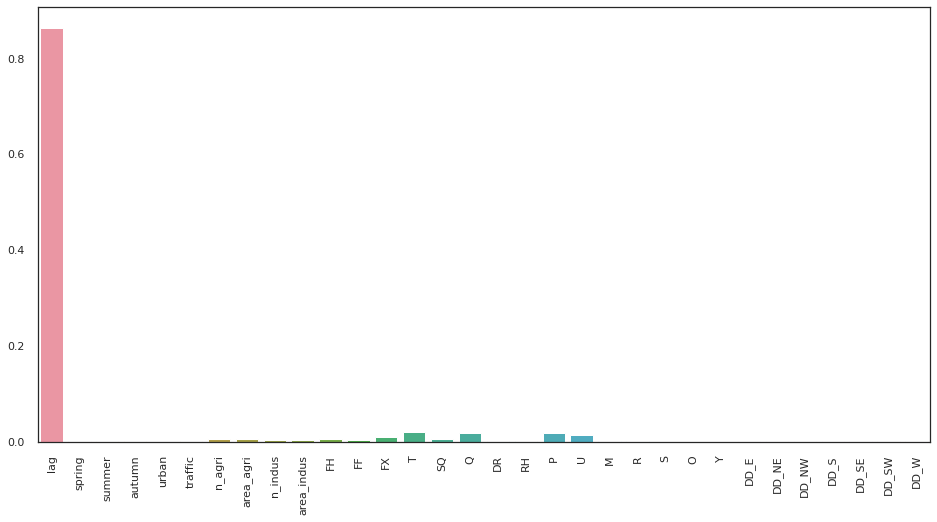

In [ ]:
# Show the feature importances in a histogram
plt.figure(figsize = (16,8))
ax = sns.barplot(data.columns[3:], importance)
plt.xticks(rotation = 90)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

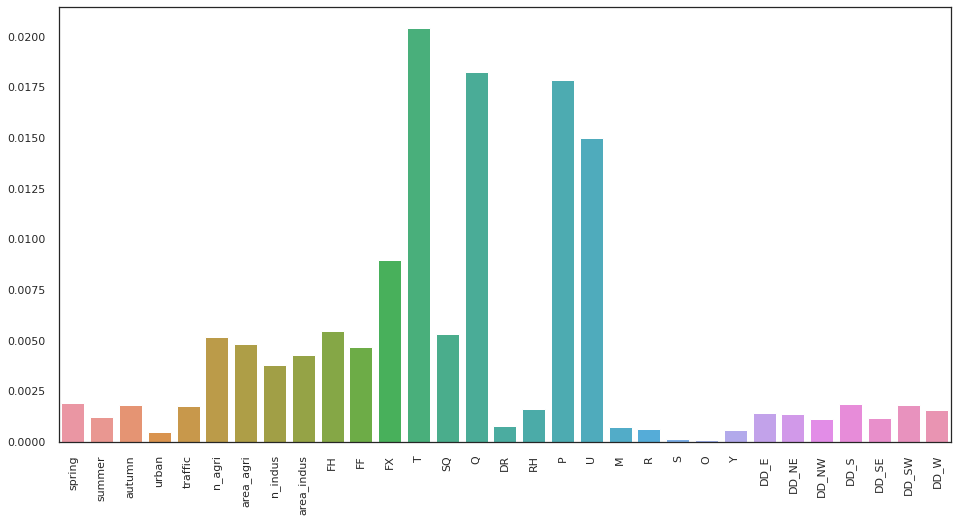

In [ ]:
# Show the importances excluding the lag variable
plt.figure(figsize = (16,8))
ax = sns.barplot(data.columns[4:], importance[1:])
plt.xticks(rotation = 90)

We can also calculate permutation feature importance for more simplistic models. This is not feasible for the Random Forest model, as it requires refitting the model 160 times!

In [ ]:
linear = LinearRegression()
linear.fit(X_val, y_val)
imp = permutation_importance(linear, X_val, y_val, scoring = 'neg_mean_squared_error')
imp2 = imp.importances_mean

array([ 2.30085742e+03,  3.32121424e-03,  3.91608741e-04,  1.53988537e-02,
        4.89060613e-01,  3.06156541e+00,  5.44481831e-02,  5.87541195e-02,
        2.81617903e+00,  6.93491964e-01,  5.77111748e+00,  3.76255985e-01,
        3.45779713e-01,  1.12669763e+00,  3.26693999e+00,  5.16660306e+00,
        1.62849521e-01, -9.37631160e-04,  7.48490348e-02,  1.60166835e+00,
        3.85120547e-01,  8.03230920e-02,  2.76419486e-03,  9.16687595e-04,
        2.45262995e-01,  3.33326539e-01,  4.12774586e-04,  1.33495667e-01,
        9.01609967e-02,  3.64181290e-02,  2.09100375e-01,  3.76773259e-02])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

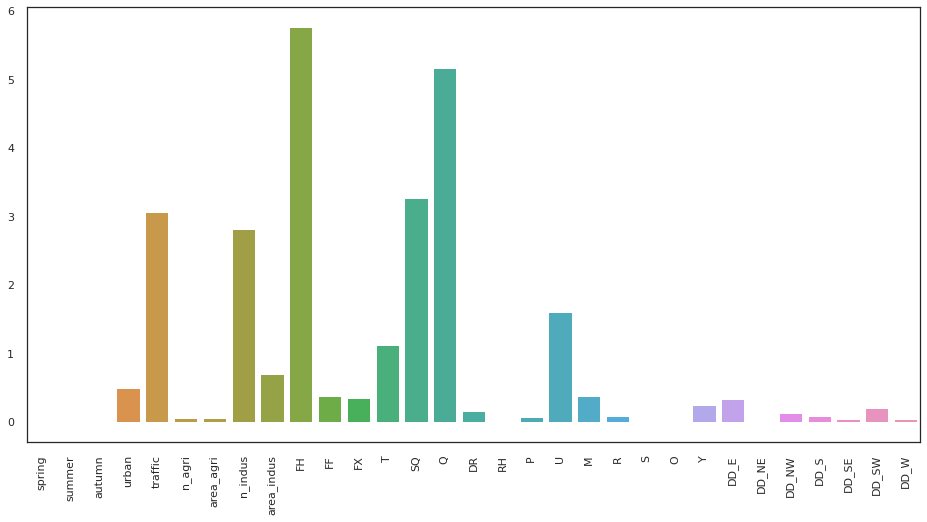

In [ ]:
# Show permutation feature importance in a histogram plot (the lag variable is excluded here, but you can include it if you like)
plt.figure(figsize = (16,8))
ax = sns.barplot(data.columns[4:], imp2[1:])
plt.xticks(rotation = 90)

This concludes our analysis. I would like to thank you for your interest in my project. If you have any questions, please reach out to me.